In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input//kaggle/input/rentaldataset-2001-2022/Real_Estate_Sales_2001-2022_Gl_CleanedSetFlatFile.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df=pd.read_csv("/kaggle/input/rentaldataset-2001-2022/Real_Estate_Sales_2001-2022_Gl_CleanedSetFlatFile.csv")

The intent of this notebook is to predict the house values using regression.
Step 1: PreProcess the data and handle missing values.
Step 2: Visualize the outliers.
Step 3: Understand the correlation between the columns
Step 4: Train the regression model.
Step 5: Tune model to get the best accuracy and least squared error.

Target is to predict the Sales amount of the house.

In [52]:
#Printing the top rows of the Dataset
df.head()

#Deleting the columns that are no important for the training.
del df['Unnamed: 10']
del df['Address']

#Identifying the null values 
null_values=df.isnull().sum()
print(null_values)



Serial Number                                2
List Year                                    2
Date Recorded                                2
Town                                         2
Assessed Value                               2
Sale Amount                                  2
Sales Ratio (Assessed Amount/Sale Amount)    2
Property Type                                2
Residential Type                             2
dtype: int64


In [53]:
#Since only two values are missing which will not impact final result, these rows are deleted from the dataset.
df = df.dropna(subset=['Serial Number'])
df = df.dropna(subset=['Sale Amount'])

In [54]:
datatype=df.dtypes
datatype

Serial Number                                float64
List Year                                    float64
Date Recorded                                 object
Town                                          object
Assessed Value                                object
Sale Amount                                   object
Sales Ratio (Assessed Amount/Sale Amount)    float64
Property Type                                 object
Residential Type                              object
dtype: object

In [55]:
#Converting the relevant columns to numerical to help in visualization in later code. 
df['List Year']=df['List Year'].astype(int)
df['Serial Number']=df['Serial Number'].astype('Int64')
df['Date Recorded']=pd.to_datetime(df['Date Recorded'])
df['Date Recorded']=df['Date Recorded'].dt.date

df['Assessed Value']=df['Assessed Value'].str.replace('$','',regex=False)
df['Assessed Value']=df['Assessed Value'].str.replace(',','',regex=False)
df['Assessed Value']=pd.to_numeric(df['Assessed Value'])

df['Sale Amount']=df['Sale Amount'].str.replace('$','',regex=False)
df['Sale Amount']=df['Sale Amount'].str.replace(',','',regex=False)
df['Sale Amount']=pd.to_numeric(df['Sale Amount'])

datatype=df.dtypes
datatype



Serial Number                                  Int64
List Year                                      int64
Date Recorded                                 object
Town                                          object
Assessed Value                               float64
Sale Amount                                  float64
Sales Ratio (Assessed Amount/Sale Amount)    float64
Property Type                                 object
Residential Type                              object
dtype: object

In [56]:
#Check if all datatypes are consistent
df.head()



,Serial Number,List Year,Date Recorded,Town,Assessed Value,Sale Amount,Sales Ratio (Assessed Amount/Sale Amount),Property Type,Residential Type
0,2020177,2020,2021-04-14,Ansonia,133000.0,248400.0,0.535,Residential,Single Family
1,2020225,2020,2021-05-26,Ansonia,110500.0,239900.0,0.461,Residential,Three Family
2,2020348,2020,2021-09-13,Ansonia,150500.0,325000.0,0.463,Commercial,NonResidential
3,2020090,2020,2020-12-14,Ansonia,127400.0,202500.0,0.629,Residential,Two Family
4,200500,2020,2021-09-07,Avon,217640.0,400000.0,0.544,Residential,Single Family


<Axes: xlabel='List Year', ylabel='Sale Amount'>

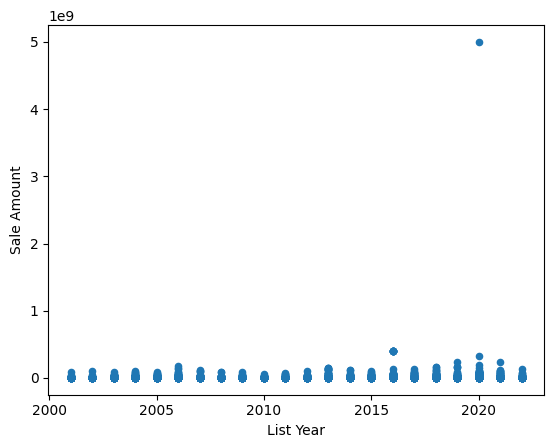

In [57]:
#Visualizing the target (sale amount) against the numerical features

df.plot.scatter(x='List Year',y='Sale Amount')


<Axes: xlabel='Residential Type', ylabel='Sale Amount'>

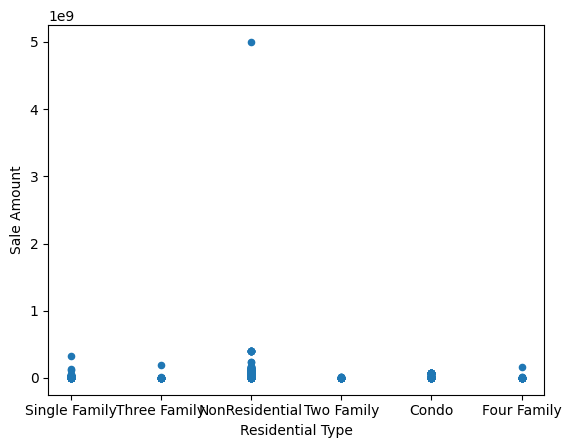

In [62]:
df.plot.scatter(x='Residential Type',y='Sale Amount')


<Axes: xlabel='Property Type', ylabel='Sale Amount'>

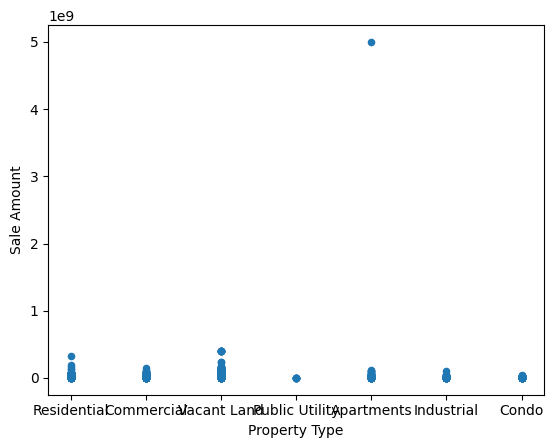

In [63]:
df.plot.scatter(x='Property Type',y='Sale Amount')

With the above visualizations, we observe that there is a single outlier. Choosing not to remove it so that we can study it further later in the analysis.

In [71]:
#Encoding the non numerical columns to numerical data to help in generating the heatmap and understand 
#the correlation between the non target columns.

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

# Fit and transform the Town column
df['Town_encoded'] = encoder.fit_transform(df[['Town']])
town_mapping = {category: index for index, category in enumerate(encoder.categories_[0])}
print("Town to Encoded Value Mapping:", town_mapping)

# Fit and transform the PropertyType column
df['PropertyType_encoded'] = encoder.fit_transform(df[['Property Type']])
propertytype_mapping = {category: index for index, category in enumerate(encoder.categories_[0])}
print("Town to Encoded Value Mapping:", propertytype_mapping)

# Fit and transform the ResidentialType column
df['ResidentialType_encoded'] = encoder.fit_transform(df[['Residential Type']])
residentialtype_mapping = {category: index for index, category in enumerate(encoder.categories_[0])}
print("Town to Encoded Value Mapping:", residentialtype_mapping)


Town to Encoded Value Mapping: {'Andover': 0, 'Ansonia': 1, 'Ashford': 2, 'Avon': 3, 'Barkhamsted': 4, 'Beacon Falls': 5, 'Berlin': 6, 'Bethany': 7, 'Bethel': 8, 'Bethlehem': 9, 'Bloomfield': 10, 'Bolton': 11, 'Bozrah': 12, 'Branford': 13, 'Bridgeport': 14, 'Bridgewater': 15, 'Bristol': 16, 'Brookfield': 17, 'Brooklyn': 18, 'Burlington': 19, 'Canaan': 20, 'Canterbury': 21, 'Canton': 22, 'Chaplin': 23, 'Cheshire': 24, 'Chester': 25, 'Clinton': 26, 'Colchester': 27, 'Colebrook': 28, 'Columbia': 29, 'Cornwall': 30, 'Coventry': 31, 'Cromwell': 32, 'Danbury': 33, 'Darien': 34, 'Deep River': 35, 'Derby': 36, 'Durham': 37, 'East Granby': 38, 'East Haddam': 39, 'East Hampton': 40, 'East Hartford': 41, 'East Haven': 42, 'East Lyme': 43, 'East Windsor': 44, 'Eastford': 45, 'Easton': 46, 'Ellington': 47, 'Enfield': 48, 'Essex': 49, 'Fairfield': 50, 'Farmington': 51, 'Franklin': 52, 'Glastonbury': 53, 'Goshen': 54, 'Granby': 55, 'Greenwich': 56, 'Griswold': 57, 'Groton': 58, 'Guilford': 59, 'Hadda

,Serial Number,List Year,Date Recorded,Town,Assessed Value,Sale Amount,Sales Ratio (Assessed Amount/Sale Amount),Property Type,Residential Type,Town_encoded,PropertyType_encoded,ResidentialType_encoded
0,2020177,2020,2021-04-14,Ansonia,133000.0,248400.0,0.535,Residential,Single Family,1.0,5.0,3.0
1,2020225,2020,2021-05-26,Ansonia,110500.0,239900.0,0.461,Residential,Three Family,1.0,5.0,4.0
2,2020348,2020,2021-09-13,Ansonia,150500.0,325000.0,0.463,Commercial,NonResidential,1.0,1.0,2.0
3,2020090,2020,2020-12-14,Ansonia,127400.0,202500.0,0.629,Residential,Two Family,1.0,5.0,5.0
4,200500,2020,2021-09-07,Avon,217640.0,400000.0,0.544,Residential,Single Family,3.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1048568,210469,2021,2022-02-03,New Haven,417165.0,385000.0,1.084,Commercial,NonResidential,92.0,1.0,2.0
1048569,2101684,2021,2022-06-08,Stamford,139480.0,169000.0,0.825,Residential,Condo,134.0,5.0,0.0
1048570,210371,2021,2022-05-10,South Windsor,162800.0,296000.0,0.550,Residential,Condo,129.0,5.0,0.0
1048571,211229,2021,2022-08-19,New Haven,150570.0,310000.0,0.486,Residential,Condo,92.0,5.0,0.0


In [60]:
#The final columns are shown below. 
df.head()

,Serial Number,List Year,Date Recorded,Town,Assessed Value,Sale Amount,Sales Ratio (Assessed Amount/Sale Amount),Property Type,Residential Type,Town_encoded,PropertyType_encoded,ResidentialType_encoded
0,2020177,2020,2021-04-14,Ansonia,133000.0,248400.0,0.535,Residential,Single Family,1.0,5.0,3.0
1,2020225,2020,2021-05-26,Ansonia,110500.0,239900.0,0.461,Residential,Three Family,1.0,5.0,4.0
2,2020348,2020,2021-09-13,Ansonia,150500.0,325000.0,0.463,Commercial,NonResidential,1.0,1.0,2.0
3,2020090,2020,2020-12-14,Ansonia,127400.0,202500.0,0.629,Residential,Two Family,1.0,5.0,5.0
4,200500,2020,2021-09-07,Avon,217640.0,400000.0,0.544,Residential,Single Family,3.0,5.0,3.0


In [68]:
#We will create a new dataframe with only the encoded columns to ensure that the number of columns 
#in our final dataframe is only what we need to do the further model training and analysis.

columns_to_keep = ['Serial Number','List Year','Town_encoded','PropertyType_encoded','ResidentialType_encoded', 'Sale Amount']
df_final = df[columns_to_keep]
df_final.head()

,Serial Number,List Year,Town_encoded,PropertyType_encoded,ResidentialType_encoded,Sale Amount
0,2020177,2020,1.0,5.0,3.0,248400.0
1,2020225,2020,1.0,5.0,4.0,239900.0
2,2020348,2020,1.0,1.0,2.0,325000.0
3,2020090,2020,1.0,5.0,5.0,202500.0
4,200500,2020,3.0,5.0,3.0,400000.0


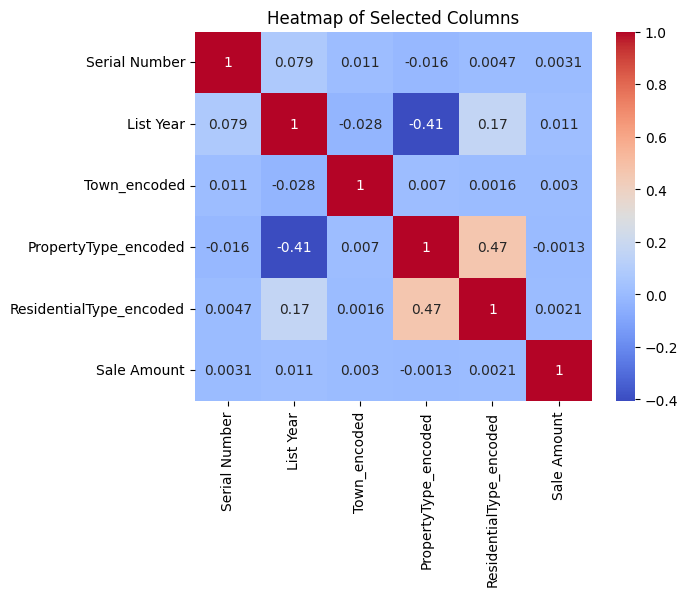

In [72]:
#Visualize using heatmap
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the correlation matrix
correlation_matrix = df_final.corr()

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Selected Columns')
plt.show()

Based on the above data we see that the features are not highly correlated with each other and hence we dont need to combine or remove any of them

Model Training -- Regression analysis is a commonly used statistical technique for predicting the relationship between a dependent variable and one or more independent variables. In real world scenarios, regression algorithms are commonly used to predict continuous variables like housing prices, student scores, stock prices, etc. 

Commonly used algorithms are Linear Regression, Polynomial Regression and Decision Tree based regression.

In [124]:
#Training using linear regression

from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

#Creating feature Variables for training
columns_to_keep =['List Year','Town_encoded','ResidentialType_encoded','Sale Amount']
df_model = df[columns_to_keep]
X = df_model.drop('Sale Amount', axis=1)
y = df_model['Sale Amount'] 
print(X) 
print(y)


         List Year  Town_encoded  ResidentialType_encoded
0             2020           1.0                      3.0
1             2020           1.0                      4.0
2             2020           1.0                      2.0
3             2020           1.0                      5.0
4             2020           3.0                      3.0
...            ...           ...                      ...
1048568       2021          92.0                      2.0
1048569       2021         134.0                      0.0
1048570       2021         129.0                      0.0
1048571       2021          92.0                      0.0
1048572       2021         100.0                      3.0

[1048573 rows x 3 columns]
0          248400.0
1          239900.0
2          325000.0
3          202500.0
4          400000.0
             ...   
1048568    385000.0
1048569    169000.0
1048570    296000.0
1048571    310000.0
1048572    380000.0
Name: Sale Amount, Length: 1048573, dtype: float64


In [125]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=101) 

linearmodel=LinearRegression()
linearmodel.fit(X_train,y_train)
predictions = linearmodel.predict(X_test) 

print('MSE: ', mean_squared_error(y_test, predictions)) 
print('MAE : ', mean_absolute_error(y_test, predictions)) 

score = r2_score(y_test, predictions)
print('Score:',score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

MSE:  2662042783894.646
MAE :  314183.853557553
Score: 0.0009356249047305365
The accuracy of our model is 0.0%


In [82]:
linearmodel.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [127]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split

param_space = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

random_search = RandomizedSearchCV(linearmodel, param_space, n_iter=20, cv=5)
random_search.fit(X_train, y_train)

# Parameter which gives the best results
print(f"Best Hyperparameters: {random_search.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best Score: {random_search.best_score_}")

Best Hyperparameters: {'positive': True, 'n_jobs': 15, 'fit_intercept': True, 'copy_X': False}
Best Score: 0.0006012549395186806


In [133]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

columns_to_keep =['List Year','Town_encoded','ResidentialType_encoded','Sale Amount']
df_model = df[columns_to_keep]
X = df_model.drop('Sale Amount', axis=1)
y = df_model['Sale Amount'] 

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=101) 

regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

score = r2_score(y_test, y_pred)
score=abs(score)
print('Score:',score)

print("The accuracy of our model is {}%".format(round(score, 2) *100))




Mean Squared Error: 4060103164535.6733
Score: 0.5237562880055096
The accuracy of our model is 52.0%


In [159]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE 

columns_to_keep =['List Year','Town_encoded','PropertyType_encoded','ResidentialType_encoded','Sale Amount']
df_model = df[columns_to_keep]
X = df_model.drop('Sale Amount', axis=1)
y = df_model['Sale Amount'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200) 

xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 100, seed = 1000) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

score = r2_score(y_test, y_pred)
score=abs(score)
print('Score:',score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

RMSE :  1517578.612761
Score: 0.6244233643318997
The accuracy of our model is 62.0%
